# Phase 5: Model Training V1b — Multi-Pattern Binary Classifier (V2)

**Goal:** Train XGBoost to predict win/loss for 2R trades across 5 pattern types, 20 pairs, 4 timeframes

**Dataset:** ~98K labeled patterns with multi-timeframe features

**Previous V1b:** 1,194 labels across 3 pattern types and 6 pairs. This V2 has 80x more data, 5 pattern types, 4 timeframes, and HTF context.

In [1]:
# Cell 1: Load & Clean Data
import pandas as pd
import numpy as np

CSV_PATH = "/Users/muftau/Documents/programming/trading-ai/python/data/training-all.csv"

df_raw = pd.read_csv(CSV_PATH, low_memory=False)
print(f"Loaded {len(df_raw)} rows, {len(df_raw.columns)} columns")
print(f"Outcome distribution:\n{df_raw.outcome.value_counts()}")

# Filter out "pending" outcomes
df_raw = df_raw[df_raw["outcome"].isin(["win", "loss"])].reset_index(drop=True)
print(f"\nAfter filtering pending: {len(df_raw)} rows")

df = df_raw.copy()

# --- Drop always-null columns ---
null_pct = df.isnull().mean()
always_null = null_pct[null_pct > 0.99].index.tolist()
if always_null:
    print(f"Dropping always-null columns: {always_null}")
    df = df.drop(columns=always_null)

# --- Separate metadata, target, and analysis-only columns ---
metadata_cols = [
    "id", "pair", "start_timestamp", "end_timestamp",
    "entry_price", "stop_loss", "take_profit", "notes",
    "nearest_round_number", "nearest_support", "nearest_resistance",
]
target_col = "outcome"
analysis_only_cols = ["r_multiple", "bars_to_outcome", "max_favorable_excursion"]

# --- Encode target ---
df["target"] = (df["outcome"] == "win").astype(int)

# --- Encode categoricals ---
categorical_cols = ["pattern_type", "timeframe", "trend_state", "trading_session", "rsi_zone"]
# Also encode HTF trend states
htf_trend_cols = [c for c in df.columns if c.endswith("_trend_state") and c.startswith("htf_")]
categorical_cols.extend(htf_trend_cols)

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

df_raw["trend_state"] = df_raw["trend_state"].fillna("unknown")
df_raw["trading_session"] = df_raw["trading_session"].fillna("unknown")

# One-hot encode all categoricals
df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns], dtype=int)

# --- Build feature matrix ---
drop_cols = metadata_cols + [target_col] + analysis_only_cols + ["target", "quality_rating"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols]
y = df["target"]

print(f"\nFeature matrix: {X.shape}")
print(f"Features ({len(feature_cols)})")
print(f"\nTarget: {y.value_counts().to_dict()}")
print(f"\nNull counts in features (top 10):")
null_counts = X.isnull().sum()
print(null_counts[null_counts > 0].sort_values(ascending=False).head(10))

Loaded 103958 rows, 85 columns
Outcome distribution:
outcome
loss       63149
win        33416
pending     7393
Name: count, dtype: int64

After filtering pending: 96565 rows

Feature matrix: (96565, 104)
Features (104)

Target: {0: 63149, 1: 33416}

Null counts in features (top 10):
htf_h1_ema_200           71781
htf_h1_sma_50            71277
htf_h1_macd_histogram    71224
htf_h1_adx               71200
htf_h1_bb_lower          71178
htf_h1_bb_upper          71178
htf_h1_sma_20            71178
htf_h1_atr               71169
htf_h1_rsi               71169
htf_h1_close             71132
dtype: int64


In [2]:
# Cell 2: Time-Based Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

train_wins = y_train.sum()
train_losses = len(y_train) - train_wins

print(f"Train: {len(X_train)} rows ({train_losses} loss, {train_wins} win)")
print(f"Test:  {len(X_test)} rows ({len(y_test) - y_test.sum()} loss, {y_test.sum()} win)")
print(f"\nTrain win rate: {train_wins / len(y_train):.1%}")
print(f"Test win rate:  {y_test.sum() / len(y_test):.1%}")
print(f"\nscale_pos_weight: {train_losses / train_wins:.2f}")

Train: 77252 rows (51635 loss, 25617 win)
Test:  19313 rows (11514 loss, 7799 win)

Train win rate: 33.2%
Test win rate:  40.4%

scale_pos_weight: 2.02


=== V1b Model Performance ===
Accuracy:  0.635
Precision: 0.537
Recall:    0.696
F1 Score:  0.606
AUC-ROC:   0.704

Baseline (always predict majority): 0.596

              precision    recall  f1-score   support

        loss       0.74      0.59      0.66     11514
         win       0.54      0.70      0.61      7799

    accuracy                           0.64     19313
   macro avg       0.64      0.64      0.63     19313
weighted avg       0.66      0.64      0.64     19313



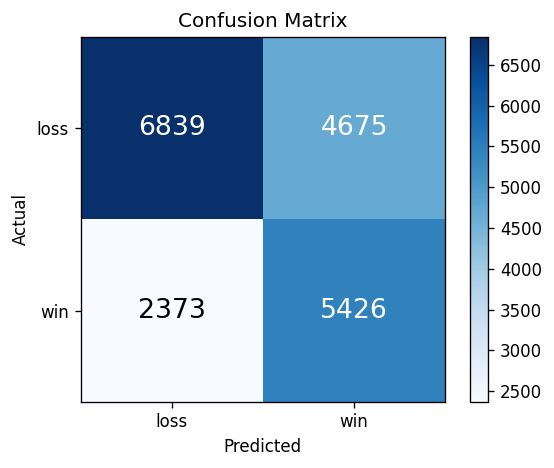

In [3]:
# Cell 3: Train XGBoost V1b & Evaluate
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 120

spw = (len(y_train) - y_train.sum()) / y_train.sum()

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=spw,
    eval_metric="logloss",
    random_state=42,
    enable_categorical=False,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("=== V1b Model Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, y_prob):.3f}")
print(f"\nBaseline (always predict majority): {max(y_test.mean(), 1 - y_test.mean()):.3f}")
print(f"\n{classification_report(y_test, y_pred, target_names=['loss', 'win'], zero_division=0)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["loss", "win"])
ax.set_yticklabels(["loss", "win"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=16)
plt.colorbar(im)
plt.tight_layout()
plt.show()

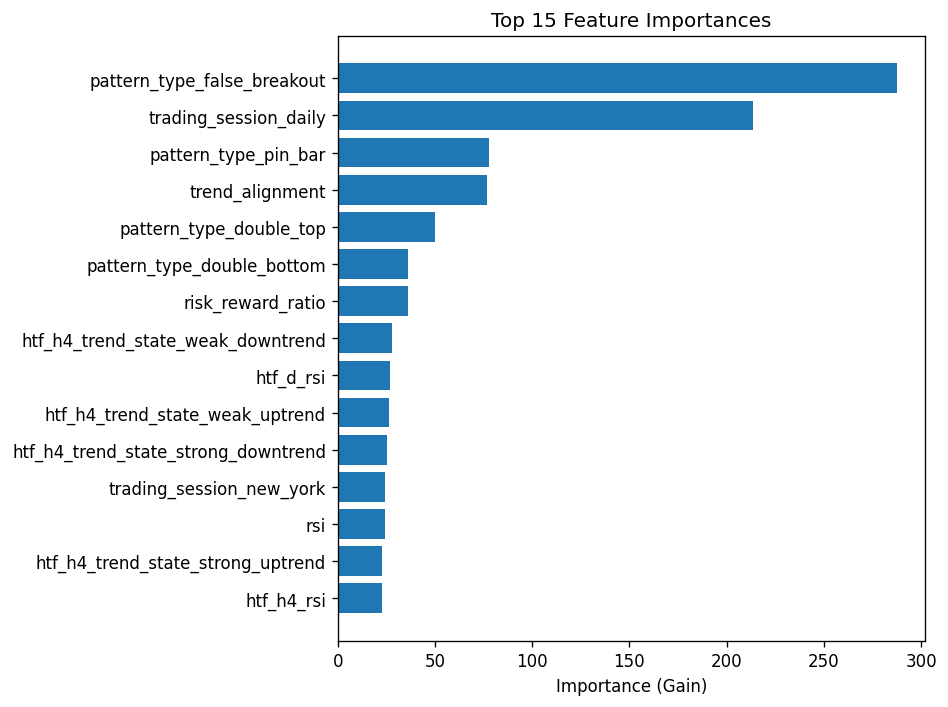


Top 15 features:
  pattern_type_false_breakout    287.55
  trading_session_daily          213.75
  pattern_type_pin_bar           77.81
  trend_alignment                76.64
  pattern_type_double_top        49.98
  pattern_type_double_bottom     36.18
  risk_reward_ratio              36.08
  htf_h4_trend_state_weak_downtrend 27.97
  htf_d_rsi                      27.11
  htf_h4_trend_state_weak_uptrend 26.39
  htf_h4_trend_state_strong_downtrend 25.58
  trading_session_new_york       24.45
  rsi                            24.20
  htf_h4_trend_state_strong_uptrend 22.74
  htf_h4_rsi                     22.69


In [4]:
# Cell 4: Feature Importance (Task 5.3)
importances = model.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame(
    {"feature": importances.keys(), "importance": importances.values()}
).sort_values("importance", ascending=True)

top_n = min(15, len(imp_df))
top = imp_df.tail(top_n)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top["feature"], top["importance"])
ax.set_xlabel("Importance (Gain)")
ax.set_title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} features:")
for _, row in imp_df.tail(top_n).iloc[::-1].iterrows():
    print(f"  {row['feature']:30s} {row['importance']:.2f}")

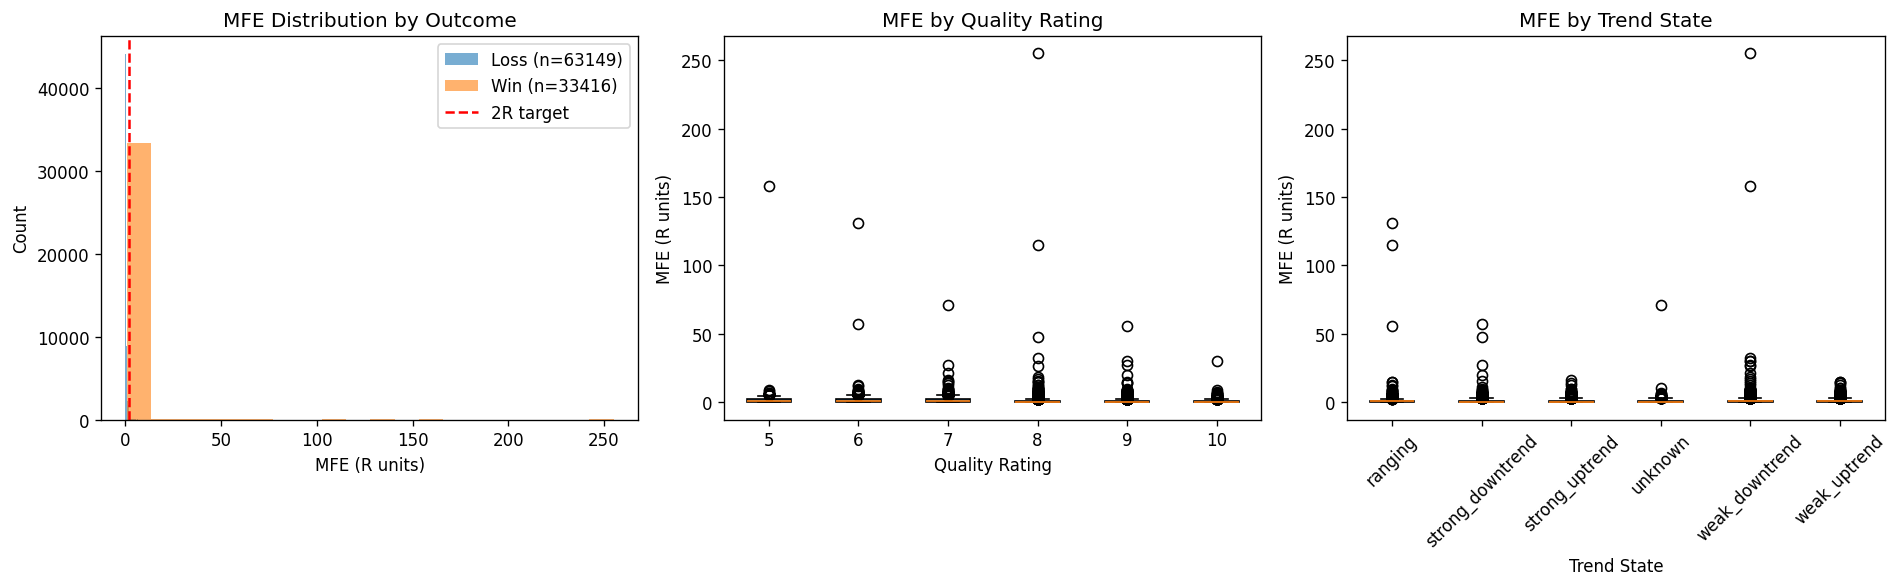

=== MFE Summary ===
Win  MFE: mean=1.75R, median=1.22R
Loss MFE: mean=0.29R, median=0.05R

Losses with MFE >= 1R: 5623 / 63149 (8.9%)
  ^ These are trades that moved favorably 1R+ but didn't reach 2R -- V2/V3 could capture these.

Losses with MFE >= 1.5R: 2401 / 63149 (3.8%)
  ^ Trades that nearly hit 2R -- strong case for dynamic TP.


In [5]:
# Cell 5: MFE Distribution Analysis (Task 5.3)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

wins_mfe = df_raw[df_raw["outcome"] == "win"]["max_favorable_excursion"]
losses_mfe = df_raw[df_raw["outcome"] == "loss"]["max_favorable_excursion"]

# 5a: MFE histogram by outcome
ax = axes[0]
ax.hist(losses_mfe, bins=20, alpha=0.6, label=f"Loss (n={len(losses_mfe)})")
ax.hist(wins_mfe, bins=20, alpha=0.6, label=f"Win (n={len(wins_mfe)})")
ax.axvline(x=2.0, color="red", linestyle="--", label="2R target")
ax.set_xlabel("MFE (R units)")
ax.set_ylabel("Count")
ax.set_title("MFE Distribution by Outcome")
ax.legend()

# 5b: MFE by quality rating
ax = axes[1]
quality_groups = df_raw.groupby("quality_rating")["max_favorable_excursion"]
labels_q = sorted(df_raw["quality_rating"].dropna().unique())
data_q = [quality_groups.get_group(q).dropna().values for q in labels_q]
bp = ax.boxplot(data_q, tick_labels=[str(int(q)) for q in labels_q], patch_artist=True)
ax.set_xlabel("Quality Rating")
ax.set_ylabel("MFE (R units)")
ax.set_title("MFE by Quality Rating")

# 5c: MFE by trend state
ax = axes[2]
trend_groups = df_raw.groupby("trend_state")["max_favorable_excursion"]
labels_t = sorted(df_raw["trend_state"].unique())
data_t = [trend_groups.get_group(t).dropna().values for t in labels_t if len(trend_groups.get_group(t).dropna()) > 0]
labels_t = [t for t in labels_t if len(trend_groups.get_group(t).dropna()) > 0]
bp2 = ax.boxplot(data_t, tick_labels=labels_t, patch_artist=True)
ax.tick_params(axis="x", rotation=45)
ax.set_xlabel("Trend State")
ax.set_ylabel("MFE (R units)")
ax.set_title("MFE by Trend State")

plt.tight_layout()
plt.show()

# Key MFE stats
print("=== MFE Summary ===")
print(f"Win  MFE: mean={wins_mfe.mean():.2f}R, median={wins_mfe.median():.2f}R")
print(f"Loss MFE: mean={losses_mfe.mean():.2f}R, median={losses_mfe.median():.2f}R")
print(f"\nLosses with MFE >= 1R: {(losses_mfe >= 1.0).sum()} / {len(losses_mfe)} ({(losses_mfe >= 1.0).mean():.1%})")
print("  ^ These are trades that moved favorably 1R+ but didn't reach 2R -- V2/V3 could capture these.")
print(f"\nLosses with MFE >= 1.5R: {(losses_mfe >= 1.5).sum()} / {len(losses_mfe)} ({(losses_mfe >= 1.5).mean():.1%})")
print("  ^ Trades that nearly hit 2R -- strong case for dynamic TP.")

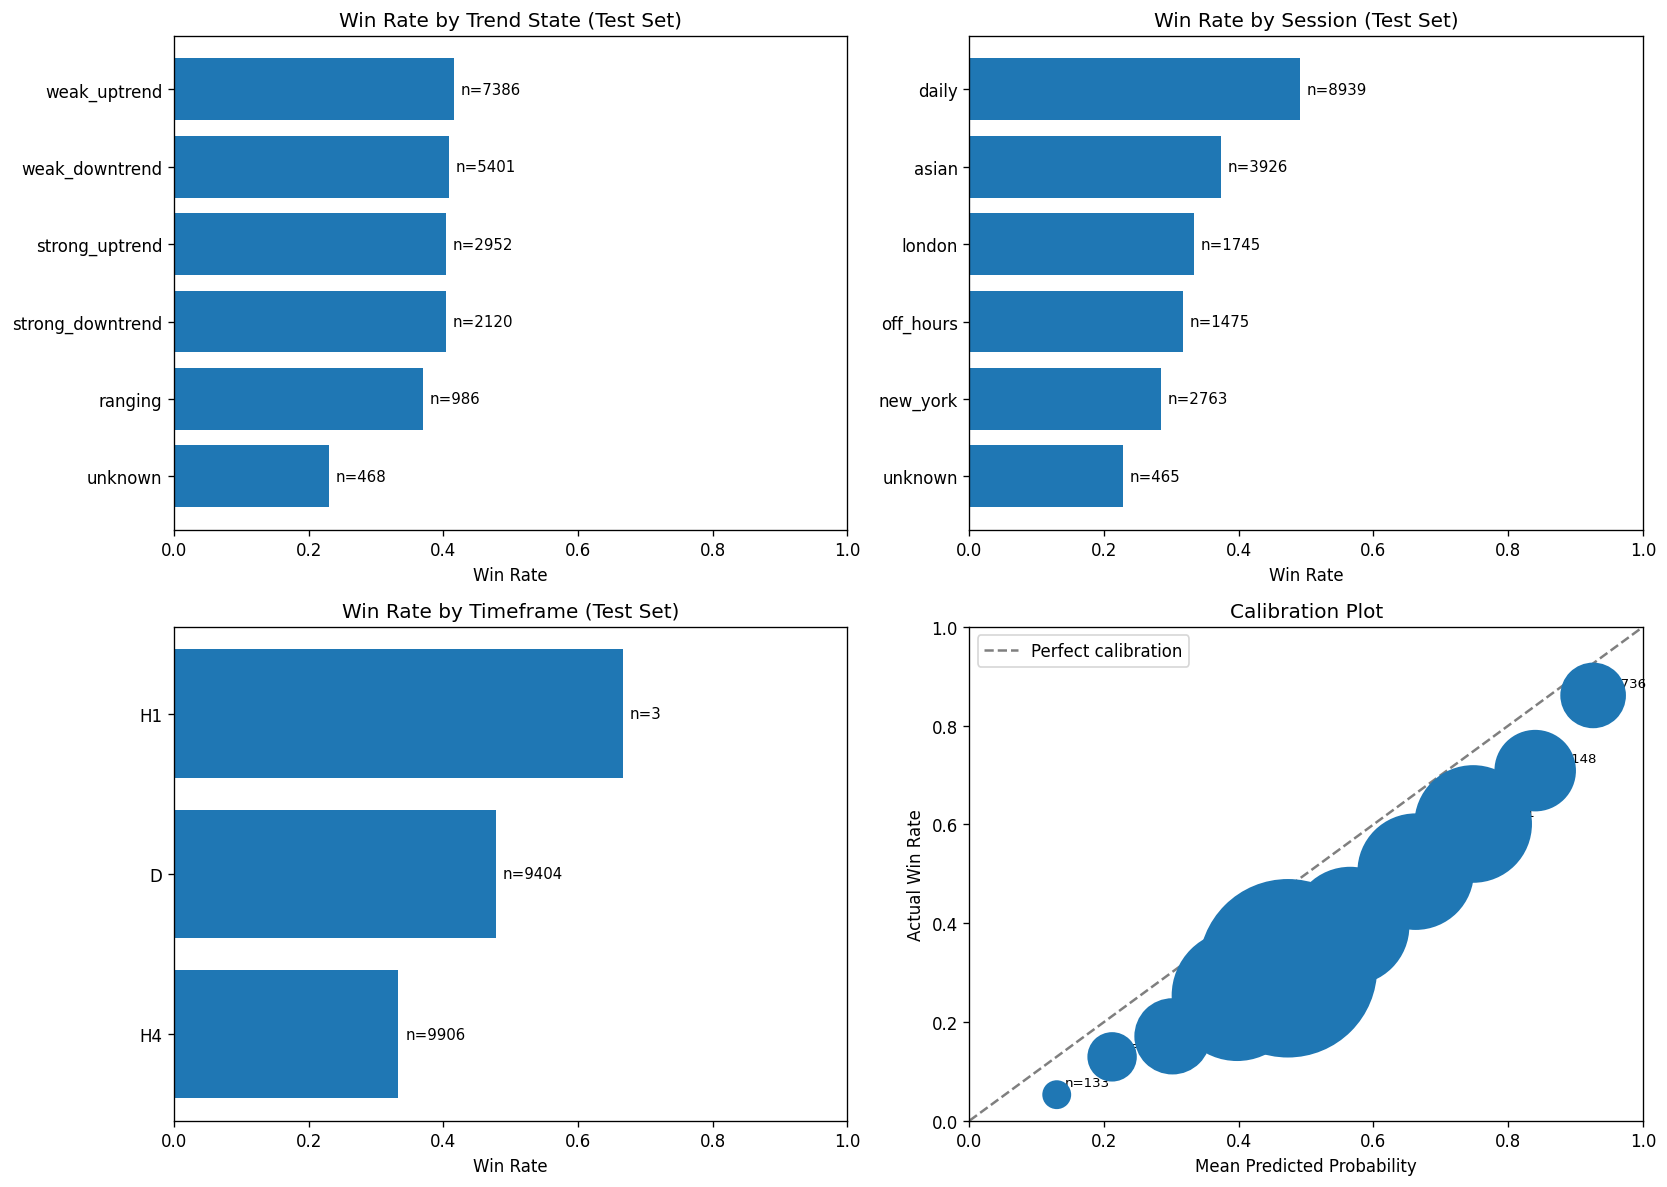

=== Context Performance (Full Dataset) ===

--- By Pattern Type ---
  double_bottom              n=25811  win_rate=33.1%  avg_mfe=0.44R
  double_top                 n=33601  win_rate=31.1%  avg_mfe=0.42R
  false_breakout             n= 9311  win_rate=65.5%  avg_mfe=2.25R
  head_and_shoulders         n=  408  win_rate=39.5%  avg_mfe=0.58R


  pin_bar                    n=27434  win_rate=29.7%  avg_mfe=1.11R

--- By Timeframe ---
  D                          n=19300  win_rate=44.6%  avg_mfe=1.36R
  H4                         n=26930  win_rate=34.4%  avg_mfe=0.75R
  H1                         n=23562  win_rate=31.2%  avg_mfe=0.63R
  M15                        n=26773  win_rate=30.6%  avg_mfe=0.58R

--- By Session ---
  asian                      n=28189  win_rate=34.8%  avg_mfe=0.72R
  daily                      n=18106  win_rate=45.7%  avg_mfe=1.41R
  london                     n=13146  win_rate=32.9%  avg_mfe=0.72R
  new_york                   n=23737  win_rate=29.0%  avg_mfe=0.58R
  off_hours                  n=12193  win_rate=31.2%  avg_mfe=0.58R
  unknown                    n= 1194  win_rate=27.7%  avg_mfe=0.67R


In [6]:
# Cell 6: Context Performance Analysis
df_test_analysis = df_raw.iloc[split_idx:].copy()
df_test_analysis["predicted"] = y_pred
df_test_analysis["predicted_prob"] = y_prob
df_test_analysis["is_win"] = (df_test_analysis["outcome"] == "win").astype(int)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 6a: Win rate by trend state
ax = axes[0, 0]
ts_stats = df_test_analysis.groupby("trend_state").agg(
    win_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
ts_stats = ts_stats[ts_stats["count"] >= 10].sort_values("win_rate", ascending=True)
bars = ax.barh(ts_stats.index, ts_stats["win_rate"])
for bar, (_, row) in zip(bars, ts_stats.iterrows()):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"n={int(row['count'])}", va="center", fontsize=9)
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate by Trend State (Test Set)")
ax.set_xlim(0, 1)

# 6b: Win rate by session
ax = axes[0, 1]
sess_stats = df_test_analysis.groupby("trading_session").agg(
    win_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
sess_stats = sess_stats[sess_stats["count"] >= 10].sort_values("win_rate", ascending=True)
bars = ax.barh(sess_stats.index, sess_stats["win_rate"])
for bar, (_, row) in zip(bars, sess_stats.iterrows()):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"n={int(row['count'])}", va="center", fontsize=9)
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate by Session (Test Set)")
ax.set_xlim(0, 1)

# 6c: Win rate by timeframe
ax = axes[1, 0]
tf_stats = df_test_analysis.groupby("timeframe").agg(
    win_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
tf_stats = tf_stats.sort_values("win_rate", ascending=True)
bars = ax.barh(tf_stats.index, tf_stats["win_rate"])
for bar, (_, row) in zip(bars, tf_stats.iterrows()):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"n={int(row['count'])}", va="center", fontsize=9)
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate by Timeframe (Test Set)")
ax.set_xlim(0, 1)

# 6d: Calibration
ax = axes[1, 1]
df_test_analysis["prob_bucket"] = pd.cut(df_test_analysis["predicted_prob"], bins=10)
cal = df_test_analysis.groupby("prob_bucket", observed=True).agg(
    mean_pred=("predicted_prob", "mean"),
    actual_rate=("is_win", "mean"),
    count=("is_win", "count"),
)
cal = cal[cal["count"] >= 10]
if len(cal) >= 2:
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect calibration")
    ax.scatter(cal["mean_pred"], cal["actual_rate"], s=cal["count"] * 2, zorder=5)
    for _, row in cal.iterrows():
        ax.annotate(f"n={int(row['count'])}",
                    (row["mean_pred"], row["actual_rate"]),
                    textcoords="offset points", xytext=(5, 5), fontsize=8)
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Actual Win Rate")
    ax.set_title("Calibration Plot")
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Full context breakdown
print("=== Context Performance (Full Dataset) ===")
df_full = df_raw.copy()
df_full["is_win"] = (df_full["outcome"] == "win").astype(int)

print("\n--- By Pattern Type ---")
for pt in sorted(df_full["pattern_type"].unique()):
    sub = df_full[df_full["pattern_type"] == pt]
    mfe = sub["max_favorable_excursion"].mean()
    print(f"  {pt:25s}  n={len(sub):5d}  win_rate={sub['is_win'].mean():.1%}  avg_mfe={mfe:.2f}R")

print("\n--- By Timeframe ---")
for tf in ["D", "H4", "H1", "M15"]:
    sub = df_full[df_full["timeframe"] == tf]
    if len(sub) == 0:
        continue
    mfe = sub["max_favorable_excursion"].mean()
    print(f"  {tf:25s}  n={len(sub):5d}  win_rate={sub['is_win'].mean():.1%}  avg_mfe={mfe:.2f}R")

print("\n--- By Session ---")
for sess in sorted(df_full["trading_session"].dropna().unique()):
    sub = df_full[df_full["trading_session"] == sess]
    mfe = sub["max_favorable_excursion"].mean()
    print(f"  {sess:25s}  n={len(sub):5d}  win_rate={sub['is_win'].mean():.1%}  avg_mfe={mfe:.2f}R")

In [7]:
# Cell 7: Save Model & Summary
import os
import json

model_dir = "/Users/muftau/Documents/programming/trading-ai/python/models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "xgb_v1b_multipattern.json")
model.save_model(model_path)
print(f"Model saved to {model_path}")

meta_path = os.path.join(model_dir, "xgb_v1b_multipattern_meta.json")
with open(meta_path, "w") as f:
    json.dump({
        "features": feature_cols,
        "n_features": len(feature_cols),
        "train_size": len(X_train),
        "test_size": len(X_test),
        "class_balance": {"loss": int(len(y) - y.sum()), "win": int(y.sum())},
        "scale_pos_weight": float(spw),
    }, f, indent=2)
print(f"Feature metadata saved to {meta_path}")

print("\n=== V1b Training Complete ===")
print(f"Dataset:    {len(X)} rows ({len(X_train)} train / {len(X_test)} test)")
print(f"Features:   {len(feature_cols)}")
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.3f} (baseline: {1 - y_test.mean():.3f})")
print(f"Precision:  {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall:     {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1:         {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"AUC-ROC:    {roc_auc_score(y_test, y_prob):.3f}")

Model saved to /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v1b_multipattern.json
Feature metadata saved to /Users/muftau/Documents/programming/trading-ai/python/models/xgb_v1b_multipattern_meta.json

=== V1b Training Complete ===
Dataset:    96565 rows (77252 train / 19313 test)
Features:   104
Accuracy:   0.635 (baseline: 0.596)
Precision:  0.537
Recall:     0.696
F1:         0.606
AUC-ROC:    0.704
